# Bidirectional LSTM seq2seq model, "state of the art is usually BiLSTMs using Attention". This just uses BiLSTMs

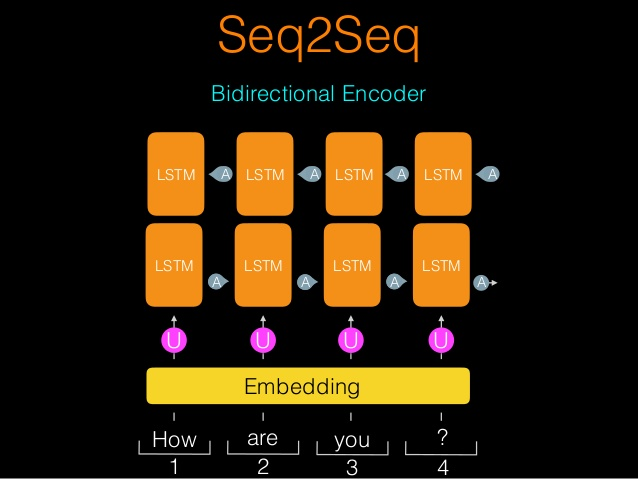

In [1]:
from IPython.display import Image
Image(filename='bi_seq2seq.jpg')
# image credits https://www.slideshare.net/samwit/tensor-flow05-neuralmachinetranslationseq2seq

In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re                      # Regular expressions
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Perform the following tasks on the data:
- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove shortwords

In [5]:
df_art_sum = pd.read_csv("train_model_files/article_summary_and_article_title/sample_1000.csv")
# bbc_art_sum.drop("Unnamed: 0", axis=1, inplace=True)
print(df_art_sum.shape)
df_art_sum.head()

(1000, 2)


,article,title
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury


In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [46]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    """
    text (str): a string of text that can be multiple sentences to be parsed into a token stream. 
    Returns: a cleaned string of text
    """
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [49]:
cleaned_text = []
for t in df_art_sum['article']:
    cleaned_text.append(text_cleaner(t))
#Call the above function
cleaned_summary = []
for t in df_art_sum['title']:
    cleaned_summary.append(summary_cleaner(t))

df_art_sum['cleaned_text']=cleaned_text
df_art_sum['cleaned_summary']=cleaned_summary
df_art_sum['cleaned_summary'].replace('', np.nan, inplace=True)
df_art_sum.dropna(axis=0,inplace=True)
for i in range(2):
    print("Review:",df_art_sum['cleaned_text'][i])
    print("Summary:",df_art_sum['cleaned_summary'][i])
    print()

Review: russian foreign minister igor ivanov said tuesday new secretary state colin powell hold first meeting feb cairo egypt
Summary: ivanov powell to meet this month 

Review: french aerobatic team patrouille france stage exciting performance hong kong oct first visit china according press release issued consulate general france hong kong wednesday
Summary: french aerobatic team to stage performance in hk 



In [60]:
# Apply start of sentence/ end of sentence tokens to summary, used for 
df_art_sum['cleaned_summary'] = df_art_sum['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok') # start of sentence token, end of sentence token
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df_art_sum['cleaned_text'],df_art_sum['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

## Tokenize, Sequence, Pad

## Tokenize list data into sequences

In [61]:
max_len_text=27
max_len_summary=15

In [63]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [65]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [66]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Pad sequences, used in model building

In [144]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 27
pad_art_sequences = pad_sequences(article_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
pad_sum_sequences = pad_sequences(summary_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print(len(article_sequences[1]), len(pad_art_sequences[1]))
print(pad_art_sequences.shape)
pad_art_sequences

35 27
(1000, 27)


array([[246,  75,  51, ...,   0,   0,   0],
       [127, 151, 912, ..., 264, 913,  12],
       [351, 743, 288, ...,   0,   0,   0],
       ...,
       [445,   8, 217, ...,   0,   0,   0],
       [227,  10,  22, ...,   0,   0,   0],
       [111, 135,  73, ...,   0,   0,   0]])

## Use padded sequences to manually create inputs to encoder and decoders

In [145]:
# shape = (pad_art_sequences.shape[0], pad_art_sequences.shape[1])
# encoder_inputs = np.zeros(shape, dtype='float32')
# encoder_inputs.shape

# decoder_inputs = np.zeros(shape, dtype='float32')
# decoder_inputs.shape

# for i, seqs in enumerate(pad_art_sequences):
#     for j, seq in enumerate(seqs):
#         encoder_inputs[i, j] = seq
        
# for i, seqs in enumerate(pad_sum_sequences):
#     for j, seq in enumerate(seqs):
#         decoder_inputs[i, j] = seq

## Embedding layers using GloVe

In [70]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
word2index, embedding_matrix = load_glove_embeddings('../glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 13.2 seconds.


In [71]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [72]:
word2index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [73]:
def embedding_matrix_creater(embedding_dimention, word_index):
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above. 
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [146]:
art_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=art_word_index_1500) 
print(art_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=sum_word_index_1500)
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = int(art_embedding_matrix.shape[0]), # vocab size
                                    output_dim = int(art_embedding_matrix.shape[1]), # embedding dimension
                                    input_length = MAX_LEN,
                                    weights = [art_embedding_matrix],
                                    trainable = False)

decoder_embedding_layer = Embedding(input_dim = int(sum_embedding_matrix.shape[0]), 
                                    output_dim = int(sum_embedding_matrix.shape[1]),
                                    input_length = MAX_LEN,
                                    weights = [sum_embedding_matrix],
                                    trainable = False)

(1000, 50)
(1000, 50)


In [147]:
art_embedding_matrix

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   7.,    7.,    7., ...,    7.,    7.,    7.],
       ...,
       [2395., 2395., 2395., ..., 2395., 2395., 2395.],
       [ 319.,  319.,  319., ...,  319.,  319.,  319.],
       [ 507.,  507.,  507., ...,  507.,  507.,  507.]])

In [148]:
# https://jovianlin.io/embeddings-in-keras/
# import numpy as np
# from load_glove_embeddings import load_glove_embeddings # local function from .py file
# import re
# import numpy as np
# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import one_hot
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense
# from keras.models import Model
# from keras.layers import Input

# embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
#                             output_dim=embedding_matrix.shape[1], 
#                             input_length=MAX_LEN,
#                             weights=[embedding_matrix], 
#                             trainable=False, 
#                             name='embedding_layer')

# i = Input(shape=(MAX_LEN,), dtype='int32', name='main_input')
# x = embedding_layer(i)
# x = Flatten()(x)
# o = Dense(1, activation='sigmoid')(x)

In [149]:
# Hyperparamters

# MAX_LEN = 250
VOCAB_SIZE = 1000
EMBEDDING_DIM = 27
HIDDEN_UNITS = 200


LEARNING_RATE = 0.002
BATCH_SIZE = 32
EPOCHS = 10

In [150]:
VOCAB_SIZE = VOCAB_SIZE + 1
VOCAB_SIZE

1001

## Model architecture finished. Train and validate the model. 

In [151]:
num_samples = len(pad_sum_sequences)
decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="int32")

In [152]:
for i, seqs in enumerate(pad_sum_sequences):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [153]:
from sklearn.model_selection import train_test_split
art_train, art_test, sum_train, sum_test = train_test_split(pad_art_sequences, pad_sum_sequences, test_size=0.2)
# X_train, X_test, y_train, y_test

In [154]:
train_num = art_train.shape[0]
train_num

800

In [155]:
target_train = decoder_output_data[:train_num]
target_test = decoder_output_data[train_num:]

In [156]:
type([art_train, sum_train])

list

In [157]:
target_train.shape

(800, 27, 1001)

In [158]:
art_train

array([[768, 103,  51, ...,   1,  89,   3],
       [ 32,   8,   2, ..., 122, 949,   9],
       [511,   8, 279, ...,  10,  17,   0],
       ...,
       [  1, 251, 131, ...,   0,   0,   0],
       [604, 795, 835, ...,  43,   0,   0],
       [203,   8, 231, ...,   0,   0,   0]])

In [170]:
"""
Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
"""
encoder_inputs = Input(shape=(max_len_text,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(max_len_summary,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = Dense(y_voc_size, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)

In [171]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy") 
# I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [172]:
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.01, clipnorm=1.)
model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 27, 50)       50000       input_29[0][0]                   
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
lstm_29 (LSTM)                  [(None, 200), (None, 200800      embedding_4[3][0]                
___________________________________________________________________________________________

In [173]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                  y_tr.shape[1], 1)[:,1:],
                  epochs=2,
                  callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                  batch_size=32,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


ValueError: Error when checking input: expected input_30 to have shape (15,) but got array with shape (14,)

In [168]:
# history = model.fit([art_train, sum_train], 
#                      target_train, 
#                      epochs=EPOCHS, # will implement early stopping, see callbacks. 
#                      batch_size=BATCH_SIZE,
#                      callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
#                      validation_data=([art_test, sum_test], target_test))

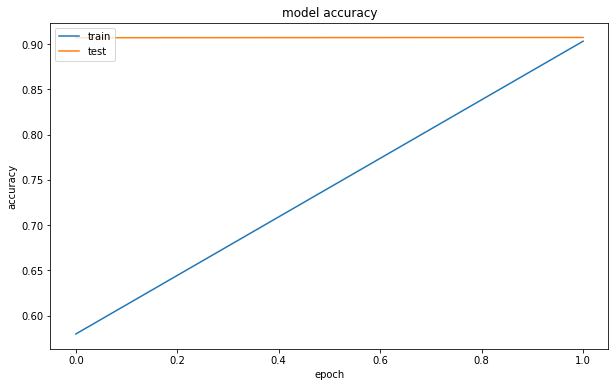

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

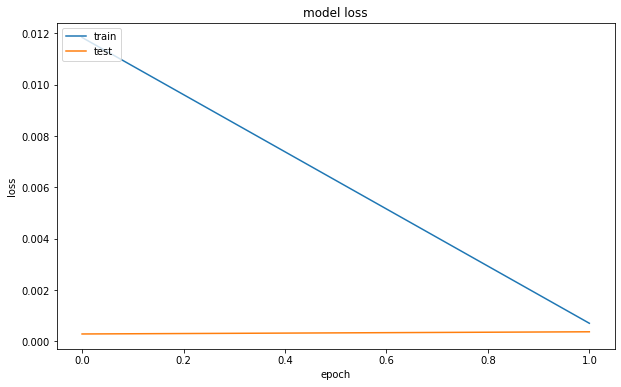

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [120]:
history.history

{'loss': [0.011840439225779846, 0.0007034696370828897],
 'accuracy': [0.579775, 0.90315],
 'val_loss': [0.0002863705065101385, 0.00037151777185499667],
 'val_accuracy': [0.907, 0.9073]}

# New

In [121]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [122]:
# Encode the input sequence to get the feature vector
latent_dim=HIDDEN_UNITS
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= decoder_embedding_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [123]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [124]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
#     print('e_out:', e_out)
#     print('e_h:', e_h)
    # works fine
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']
    # works fine
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
#         print("output_tokens:", output_tokens)
        # output tokens are usually 3
    
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
#         if sampled_token_index != 0: # loops here too many times, shouldn't have an index of 0, but consistently does. 
        sampled_token = reverse_target_word_index[sampled_token_index]
        print('sample token:', sampled_token)
        
        if(sampled_token!='eostok' and sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [125]:
for i in range(0,5):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print()
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: late gave win stoke saturday closed championship leaders sheffield united three points 
Original summary: keep up pressure 



ValueError: Error when checking input: expected input_11 to have shape (50,) but got array with shape (27,)